## Packages and Presets

In [582]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
import torch
from skimpy import clean_columns
from sklearn.model_selection import train_test_split
from pickle import load
import shap

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [583]:
SEED = 42
GRID_SIZE = 10_000

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<span style="color:red">Conceptually, how does the model compare to Logistic Regression and MLPs (1 Pt)
Seperate MLP for every feature that get aggregated in the end. The model is a combination of multiple MLPs that are trained on different features. The output of each MLP is then aggregated to get the final output. This is different from Logistic Regression where the output is a linear combination of the input features.</span>

## Loading Data and Model

In [584]:
train_df = pd.read_csv("../data/heart_failure/train_val_split.csv").pipe(
    clean_columns
)
X_train = train_df.drop(columns=["heart_disease"], axis=1)
outlier_idx = X_train.query("resting_bp == 0").index
print(f"{outlier_idx=}")
X_train = X_train.drop(outlier_idx)
y_train = train_df["heart_disease"]
y_train = y_train[X_train.index]

# create categorical variable for cholesterol level
X_train["chol_level"] = pd.cut(
    X_train["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)


outlier_idx=Index([366], dtype='int64')


We also have to load the test (X) data as they will be used later for the SHAP values:

In [585]:
test_df = pd.read_csv("../data/heart_failure/test_split.csv").pipe(clean_columns)
X_test = test_df.drop(columns=["heart_disease"], axis=1)
# create categorical variable for cholesterol
X_test["chol_level"] = pd.cut(
    X_test["cholesterol"],
    bins=[-1, 10, 200, 240, 1000],
    labels=["imputed", "normal", "borderline", "high"],
)

In [586]:
preprocessor = load(open("../models/preprocessor.pkl", "rb"))
model = torch.load("../models/neural_additive_model.pth")

In [587]:
categorical_cols = [col for col in X_train.columns if X_train.nunique()[col] < 5]
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

## Partial Dependence Plots

In this section we will try to produce partial dependence plots similar to the ones used in the [original paper](https://arxiv.org/pdf/2004.13912.pdf).

In [588]:
X_train.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,chol_level
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,high
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,high
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,borderline
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,normal
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,high


In [589]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.435221,0.431739,0.838206,1.415918,-0.806973,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.753660,-0.124829,0.783026,-1.506097,-0.806973,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.586050,0.320425,0.148452,-1.111230,0.579381,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.050829,0.988307,-0.026285,-0.558416,-0.806973,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.541367,-0.681397,1.298042,1.336945,-0.806973,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


We can see that the first five columns in X_train_preprocessed are the numeric columns. To increase interpretability of the final plots, we will inverse transform the scales of these columns for the plots. Hence, the neural additive model will be fitted on the scaled data, but the plots will be based on the original, non scaled columns.

In [590]:
X_numeric = X_train_preprocessed[:, :5]
X_categorical = X_train_preprocessed[:, 5:]

# calculate 1st and 99th percentile for each numeric feature
percentiles = np.percentile(X_numeric, [0, 100], axis=0)
percentiles

# create one grid that will be passed as input to the model to get the logits of
# the different feature NNs and one grid to plot the logits afterwards
model_grids = []
plotting_grids = []
for i in range(X_numeric.shape[1]):
    model_grids.append(np.linspace(percentiles[0, i], percentiles[1, i], GRID_SIZE))
    plotting_grids.append(np.linspace(percentiles[0, i], percentiles[1, i], GRID_SIZE))


model_grids.append(
    np.array([[0] * (GRID_SIZE // 2) + [1] * (GRID_SIZE // 2)] * X_categorical.shape[1])
)

plotting_grids.extend([np.linspace(0, 1, GRID_SIZE)] * X_categorical.shape[1])

# model input grid
input = torch.tensor(np.row_stack(model_grids).T).float()
print(f"{input.shape=}")

# grid for plots
plotting_grids = np.row_stack(plotting_grids).T
print(f"{plotting_grids.shape=}")

input.shape=torch.Size([10000, 25])
plotting_grids.shape=(10000, 25)


In [591]:
pd.DataFrame(input.numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-2.602831,-2.907669,-1.819645,-3.006591,-2.655445,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.602322,-2.907001,-1.819158,-3.006058,-2.654687,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.601812,-2.906333,-1.818672,-3.005525,-2.653929,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.601302,-2.905665,-1.818185,-3.004992,-2.653171,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.600793,-2.904997,-1.817699,-3.004458,-2.652413,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [592]:
# set model to eval mode to disable dropout
model.eval()
# get logits for each feature
feature_logits = model(input.to(DEVICE))[1].detach().cpu().numpy()


In [593]:
# bring back the transformed data to the original scale
plotting_grids_backtrans = (
    np.c_[
        preprocessor.named_transformers_["numeric"]
        .inverse_transform(plotting_grids[:, :5]),
        plotting_grids[:, 5:]
    ]
)

print(f"{plotting_grids_backtrans.shape=}")

X_train_backtrans = (
    np.c_[
        preprocessor.named_transformers_["numeric"]
        .inverse_transform(X_numeric),
        X_categorical
    ]
)
print(f"{X_train_backtrans.shape=}")

plotting_grids_backtrans.shape=(10000, 25)
X_train_backtrans.shape=(733, 25)


In [594]:
# get names of the transformed features
numeric_feature_names = preprocessor.named_transformers_[
    "numeric"
].get_feature_names_out()
categorical_feature_names = preprocessor.named_transformers_[
    "categorical"
].get_feature_names_out()
names = np.concatenate([numeric_feature_names, categorical_feature_names])
print(f"{names=}")

names=array(['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'sex_F',
       'sex_M', 'chest_pain_type_ASY', 'chest_pain_type_ATA',
       'chest_pain_type_NAP', 'chest_pain_type_TA', 'fasting_bs_0',
       'fasting_bs_1', 'resting_ecg_LVH', 'resting_ecg_Normal',
       'resting_ecg_ST', 'exercise_angina_N', 'exercise_angina_Y',
       'st_slope_Down', 'st_slope_Flat', 'st_slope_Up',
       'chol_level_borderline', 'chol_level_high', 'chol_level_imputed',
       'chol_level_normal'], dtype=object)


We have to manually clean the names of the columns for the plots:

In [595]:
names_cleaned = [
    "Age",
    "Resting Blood Pressure",
    "Cholesterol",
    "Maximum Heart Rate",
    "Old Peak",
    "Sex Female",
    "Sex Male",
    "Chest Pain: Type Asymptomatic",
    "Chest Pain: Type Atypical Angina",
    "Chest Pain: Type Non-Anginal Pain",
    "Chest Pain: Type Typical Angina",
    "Fasting Blood Sugar < 120 mg/dl",
    "Fasting Blood Sugar > 120 mg/dl",
    "Resting ECG: Left Ventricular Hypertrophy",
    "Resting ECG: Normal",
    "Resting ECG: ST-T Wave Abnormality",
    "Exercise-Induced Angina: No",
    "Exercise-Induced Angina: Yes",
    "ST Slope: Downsloping",
    "ST Slope: Flat",
    "ST Slope: Upsloping",
    "Cholesterol Level: Borderline",
    "Cholesterol Level: High",
    "Cholesterol Level: Imputed",
    "Cholesterol Level: Normal"    
]

assert len(names_cleaned) == len(names)

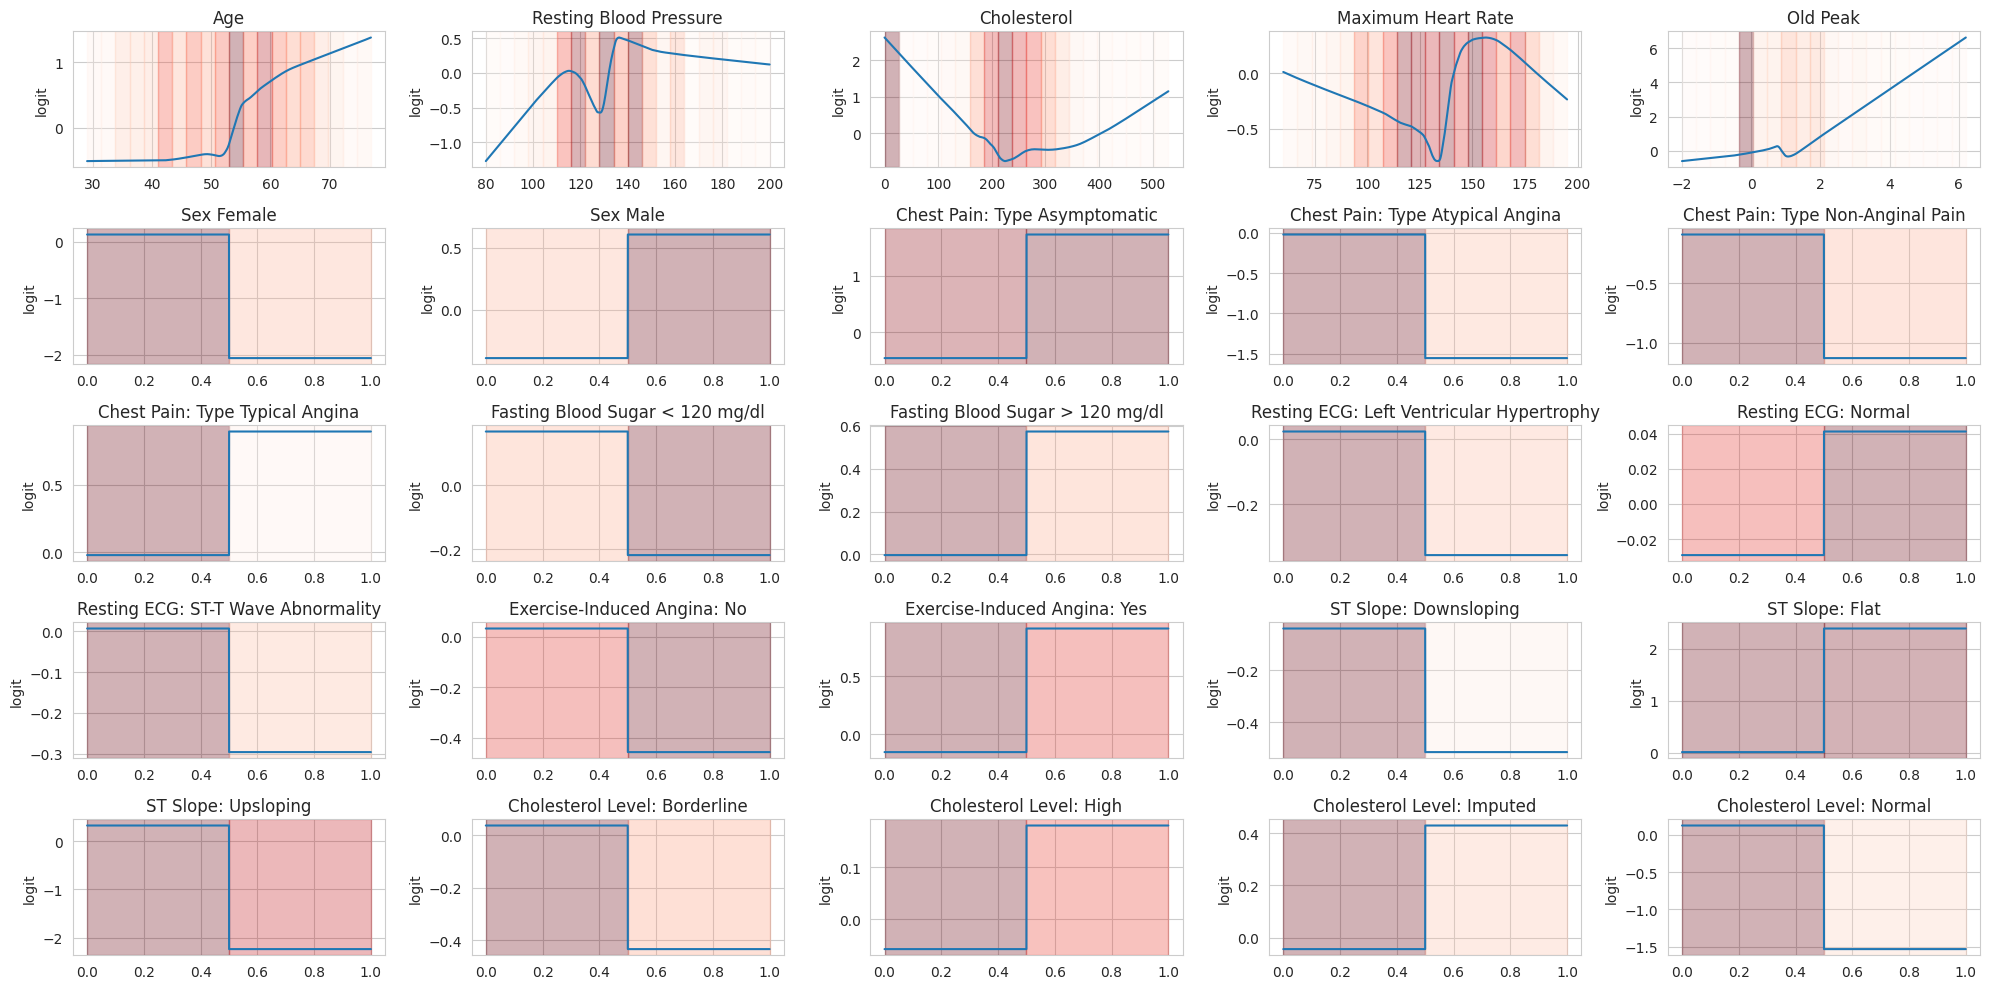

In [596]:
# plot every column vs the corresponding logits column
fig, axs = plt.subplots(5, 5, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(plotting_grids_backtrans[:, i], feature_logits[:, i])
    if i < 5:
        counts, bins = np.histogram(X_train_backtrans[:, i], bins=20)

        # create color gradient for counts:
        norm = plt.Normalize(0, counts.max())
        colors = plt.cm.Reds(norm(counts))
        
        # bars in the background that indicate the distribution of the variable
        for j in range(len(bins) - 1):
            ax.axvspan(xmin=bins[j], xmax=bins[j + 1], color=colors[j], alpha=0.3)

    else:
        counts, bins = np.histogram(X_train_backtrans[:, i], bins=2)

        # create color gradient for counts:
        norm = plt.Normalize(0, counts.max())
        colors = plt.cm.Reds(norm(counts))
        
        # bars in the background that indicate the distribution of the variable
        for j in range(len(bins) - 1):
            ax.axvspan(xmin=bins[j], xmax=bins[j + 1], color=colors[j], alpha=0.3)

    ax.set_title(f"{names_cleaned[i]}")
    ax.set_xlabel("")
    ax.set_ylabel("logit")
plt.tight_layout()
plt.show()

## SHAP Values

Since our model returns two outputs but the DeepExplainer only expects one, we will first have to write a class that only returns the first output of the model (and reshape it). We will then use this class to calculate the SHAP values:

In [597]:
class NAM_Summed_Logits(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # have to add a dimension since explainer did not work otherwise
        return self.model(x)[0].unsqueeze(-1)

In [598]:
model_summed_logits = NAM_Summed_Logits(model)

train_x = torch.tensor(X_train_preprocessed).float().to(DEVICE)
test_x = torch.tensor(X_test_preprocessed).float().to(DEVICE)

explainer = shap.DeepExplainer(
    model_summed_logits, train_x
)

shap_values = explainer.shap_values(test_x)

/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LinearLayer
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [599]:
print(f"{shap_values.shape=}")

shap_values.shape=(184, 25, 1)


Note that the SHAP values for some reason have a third dimension. Thus, we will have to reshape the shap_values array to avoid errors in the plotting function.

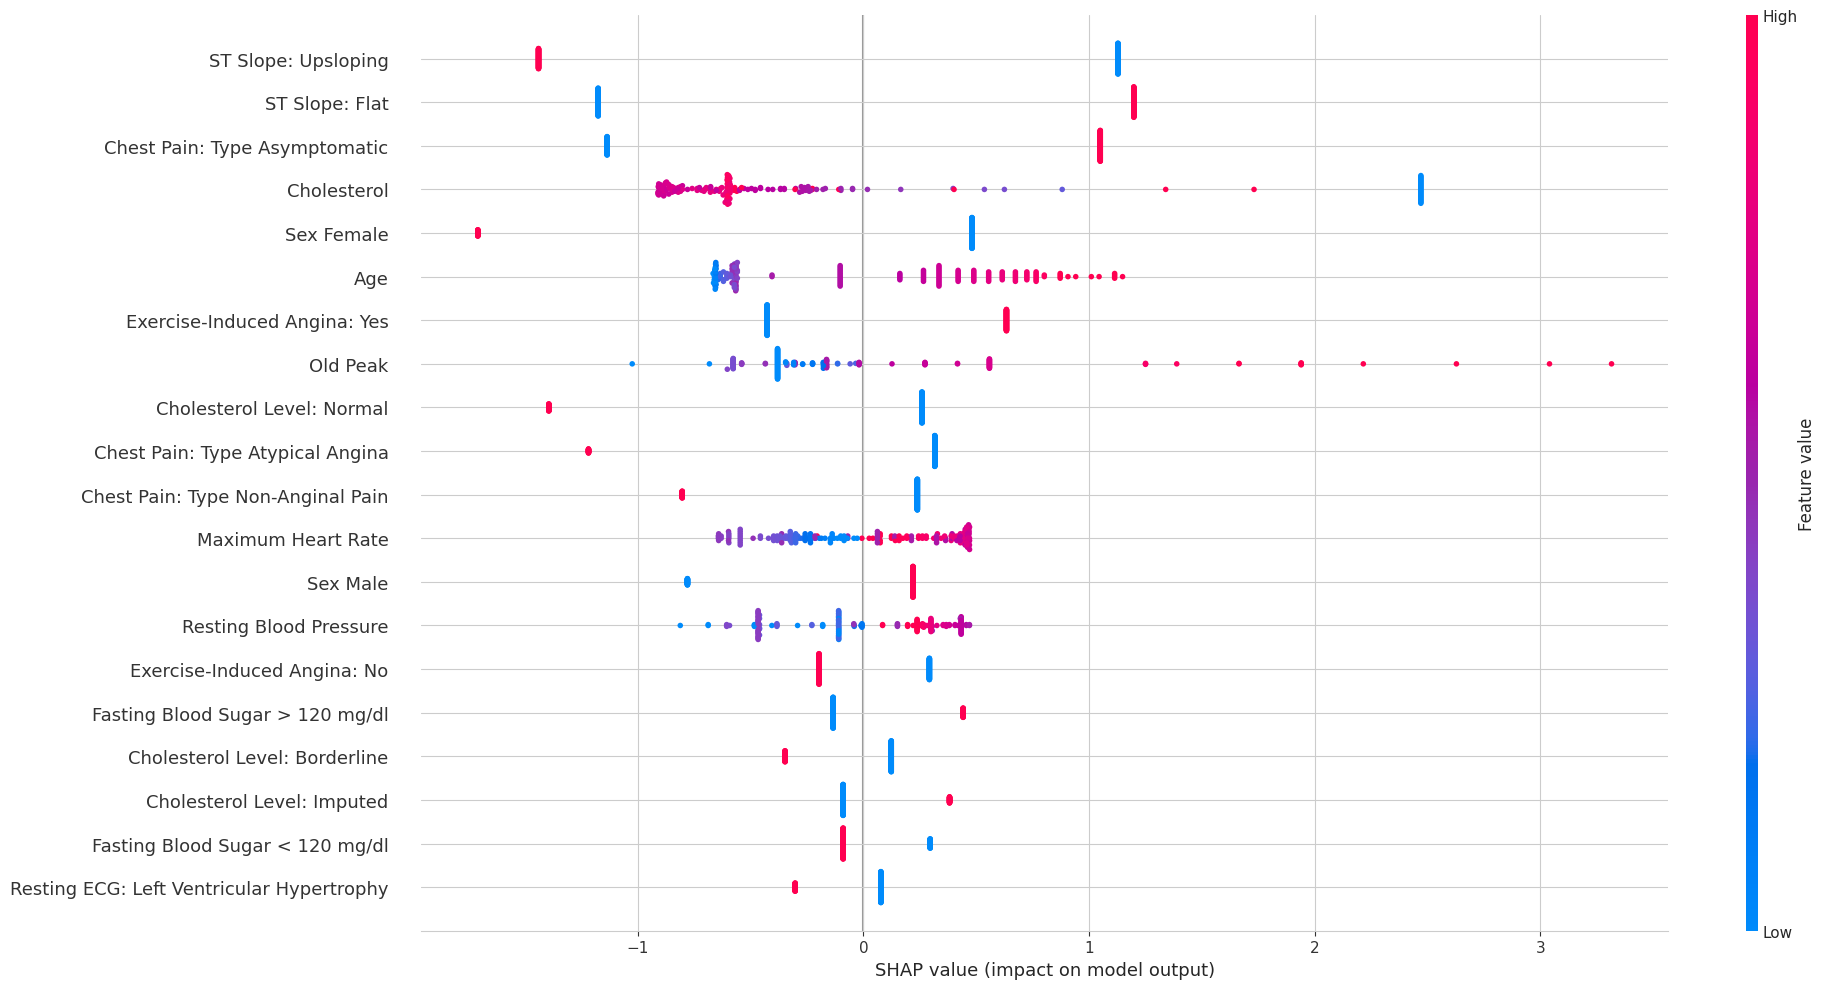

In [600]:
# create dataframe for plotting
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=names_cleaned)

shap.summary_plot(
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    plot_type="dot",
    plot_size=[20, 10],
)

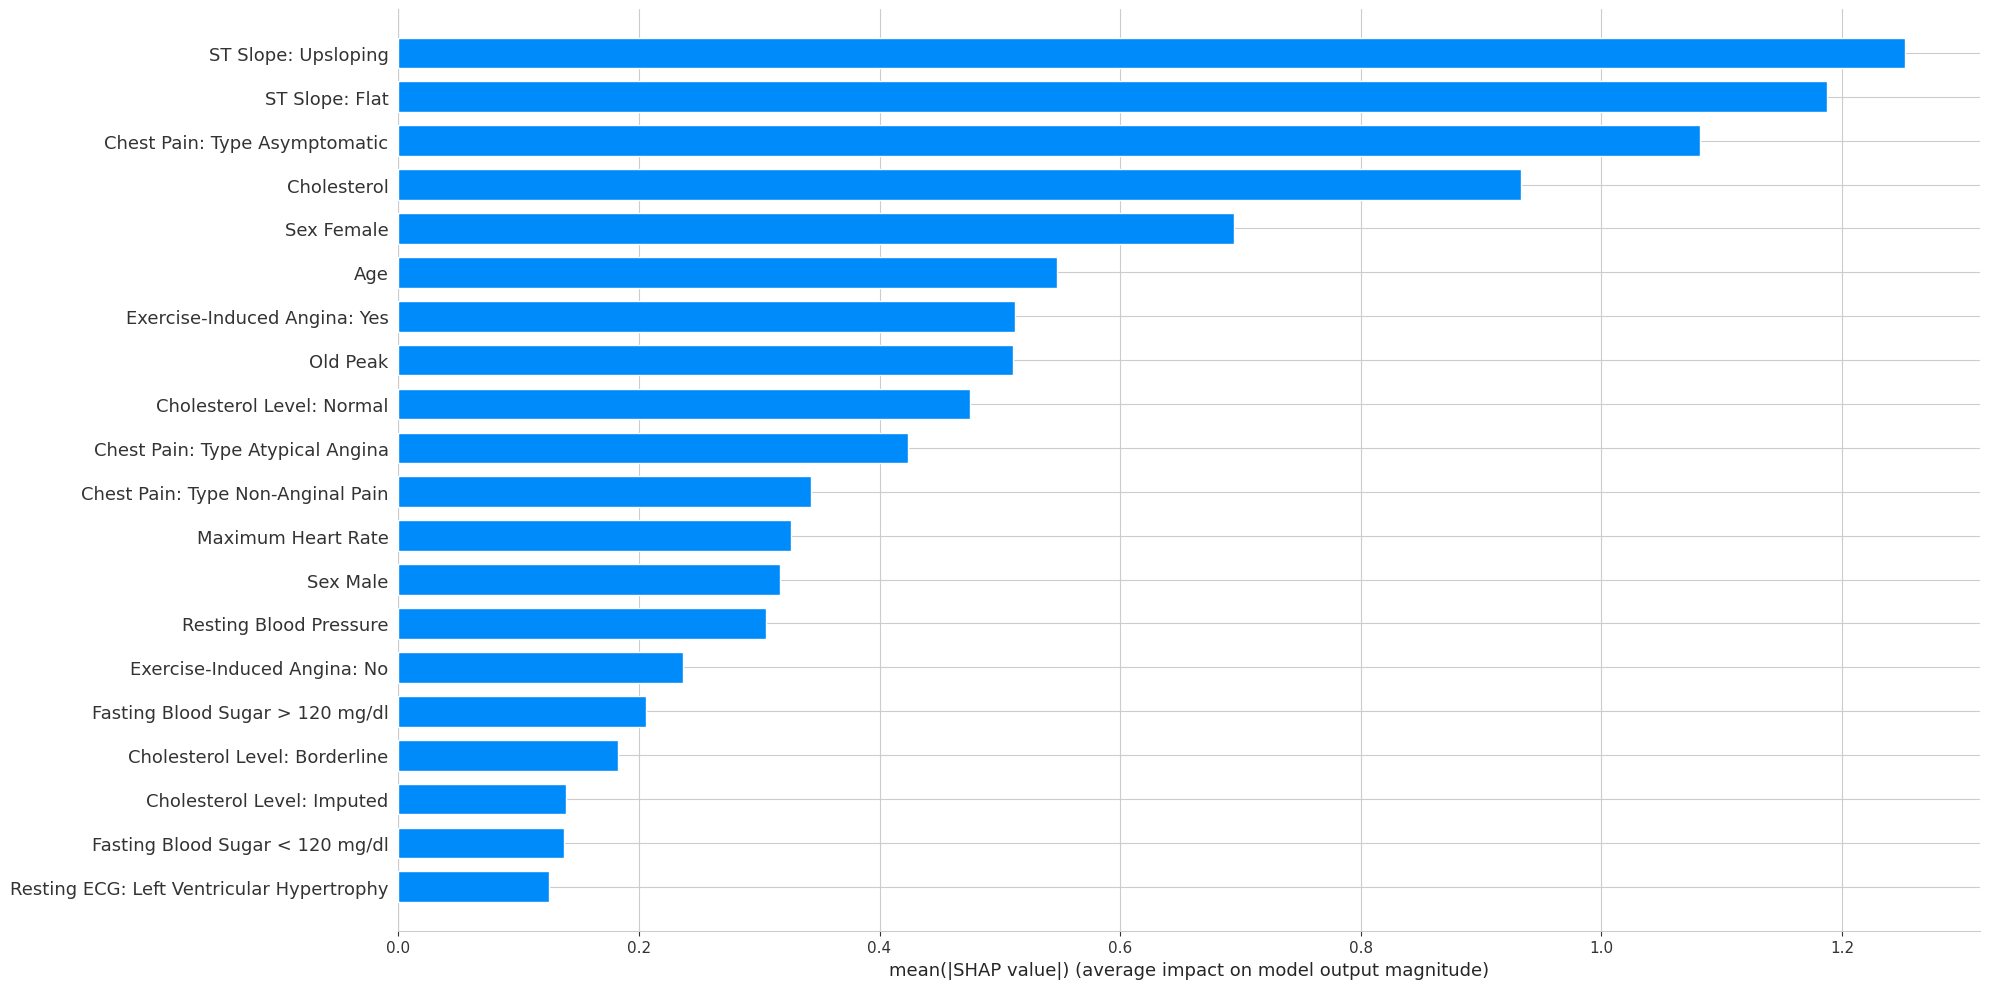

In [601]:
shap.summary_plot(
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    plot_type="bar",
    plot_size=[20, 10],
)

In [602]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    #matplotlib=True
)

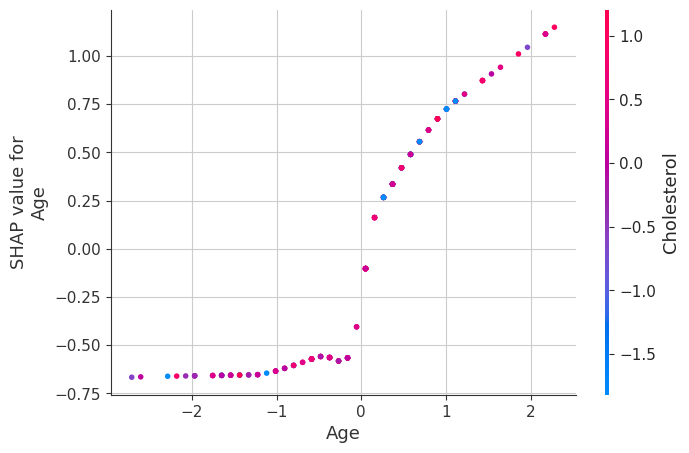

In [603]:
shap.dependence_plot(
    "Age",
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    interaction_index="Cholesterol"
)

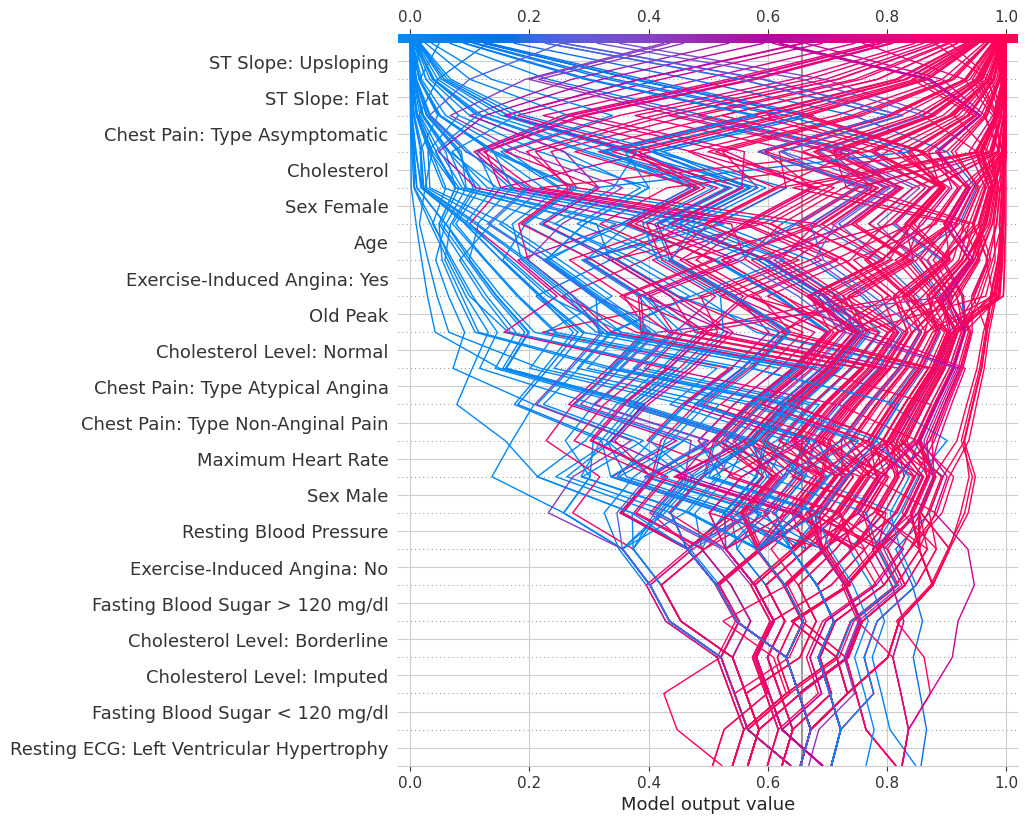

In [604]:
shap.decision_plot(
    explainer.expected_value[0],
    shap_values.reshape(-1, X_test_preprocessed_df.shape[1]),
    X_test_preprocessed_df,
    link="logit"
)